# OpenET GEESEBAL
## Image Class Property/Method Example
This example shows how to instantiate the model Image class for a single Landsat image using the ".from_landsat_c2_sr()" helper method.  This example also shows how to get the model variables.

## Setup

In [1]:
import pprint

import ee
from IPython.display import Image

import openet.geesebal as model

### Initialize Earth Engine

In [2]:
# Initialize the Earth Engine package, initiating the authentication flow if needed.
try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize()

## Analysis

In [3]:
ndvi_palette = [
    '#0010FF','#1020FF','#2030FF','#3040FF','#4050FF','#5060FF','#6070FF',
    '#7080FF','#8090FF','#90A0FF','#A0B0FF','#B0C0FF','#C0D0FF','#D0E0FF',
    '#E0F0FF','#F0FFFF',
    'ffffff',
    'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']
temp_palette = ['#380061','#2222ab','#5676d6','#83a3da','#dfdbb3','#da8c83','#d35454','#b02323','#4d0f0f']

image_size = 768

### Landsat 8 Collection 2 Level 2 Image

In [4]:
landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_044033_20170716')
# landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_038031_20130828')
# landsat_img = ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_019031_20140122')  # cloudy
# landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_027029_20160706')  # does not run

landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))
# print(landsat_img.get('system:time_start').getInfo())

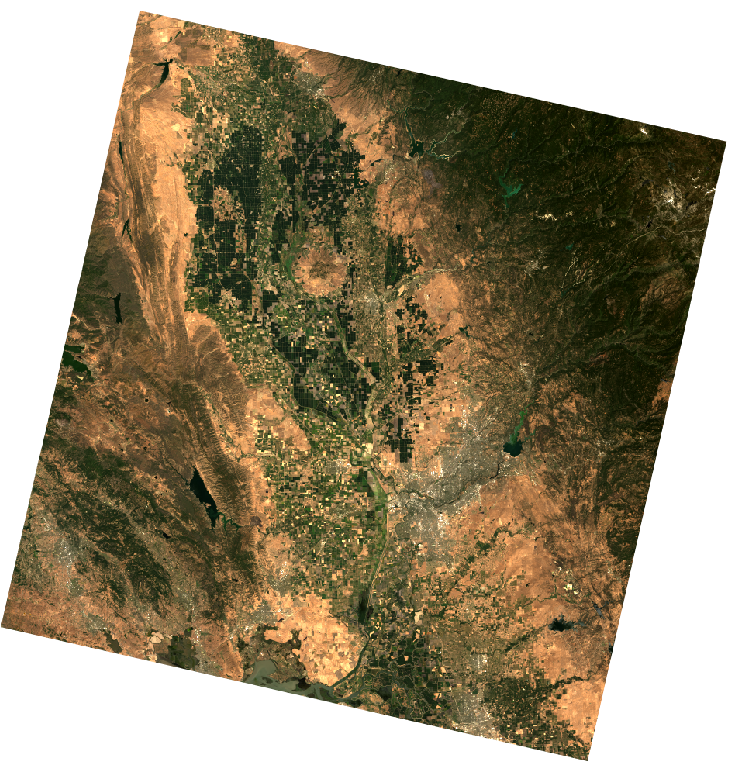

In [5]:
# True color
image_url = landsat_img.select(['SR_B4', 'SR_B3', 'SR_B2'])\
    .multiply([0.0000275]).add([-0.2])\
    .getThumbURL({'min': 0.0, 'max': 0.23, 'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [6]:
# Build the GEESEBAL model object from the Landsat image
# Set calibration points to 1 to reduce computation time
model_obj = model.Image.from_landsat_c2_sr(
    landsat_img, 
    c2_lst_correct=False,
    calibration_points=1,
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='eto', 
    # et_reference_factor=1.0,
    # et_reference_resample='bilinear',
)

### NDVI

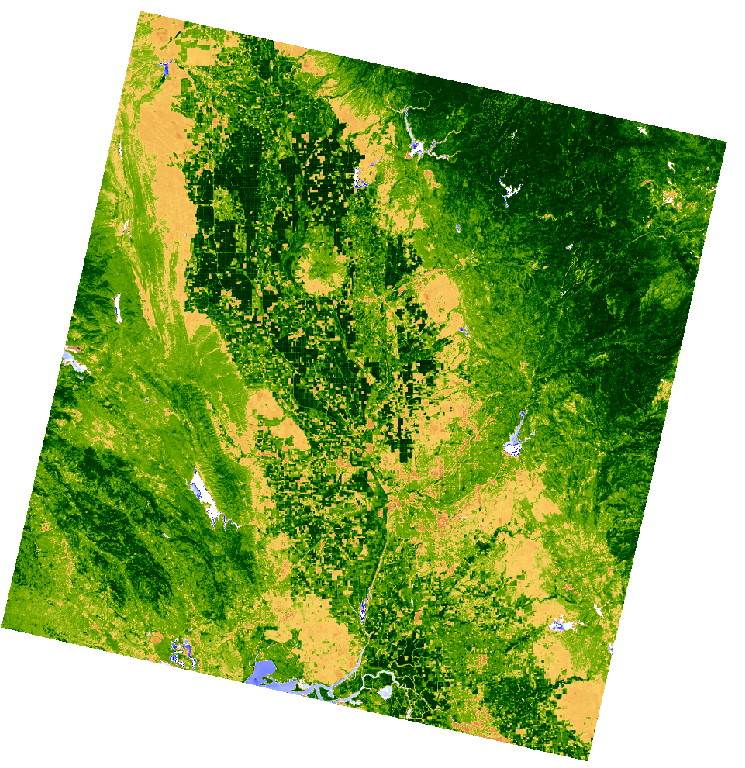

In [8]:
image_url = model_obj.ndvi\
    .getThumbURL({'min': -1, 'max': 1, 'palette': ndvi_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### LST

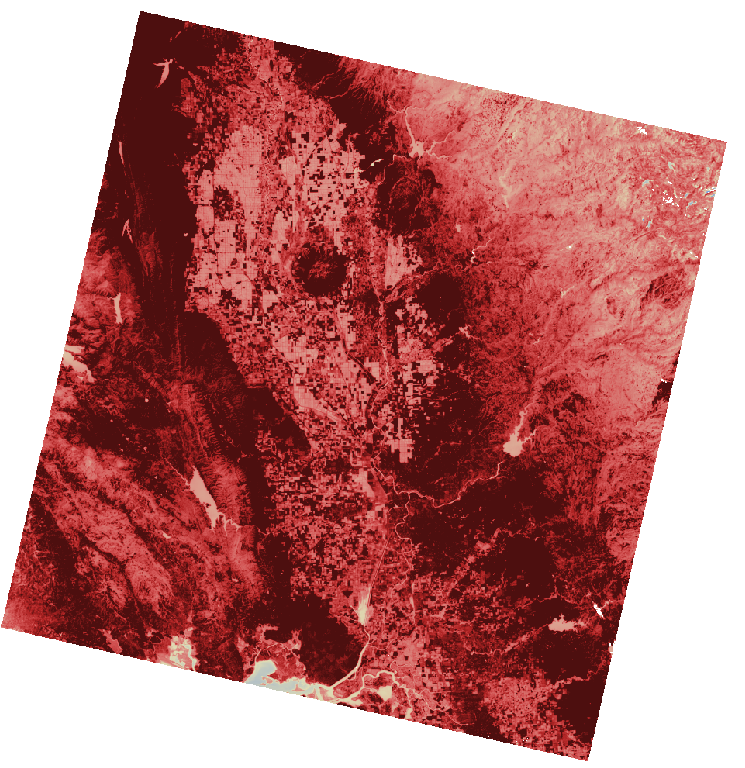

In [9]:
image_url = model_obj.lst\
    .getThumbURL({'min': 0+273.15, 'max': 50+273.15, 'palette':temp_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET

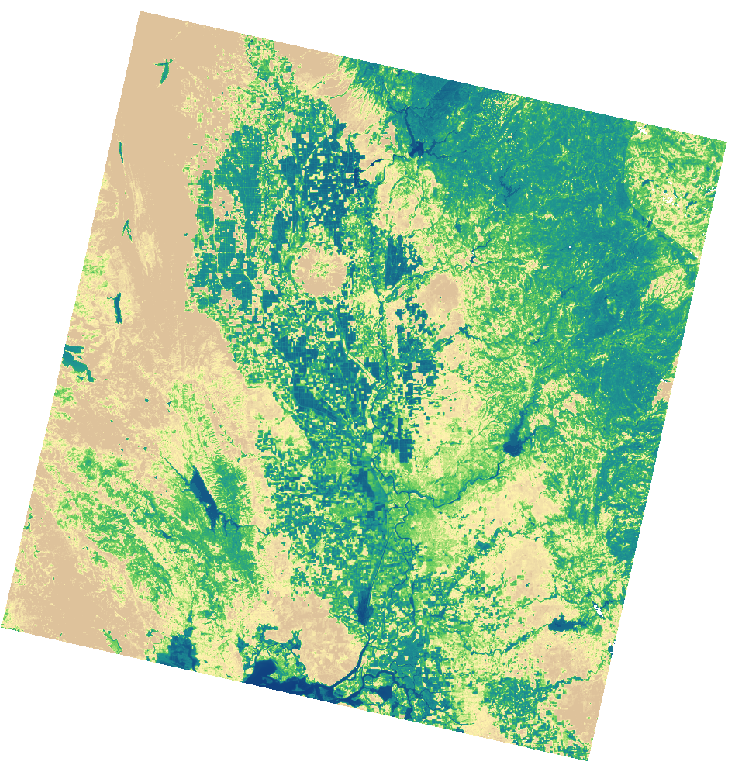

In [10]:
image_url = model_obj.et\
    .getThumbURL({'min': 0.0, 'max': 8, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Reference ET

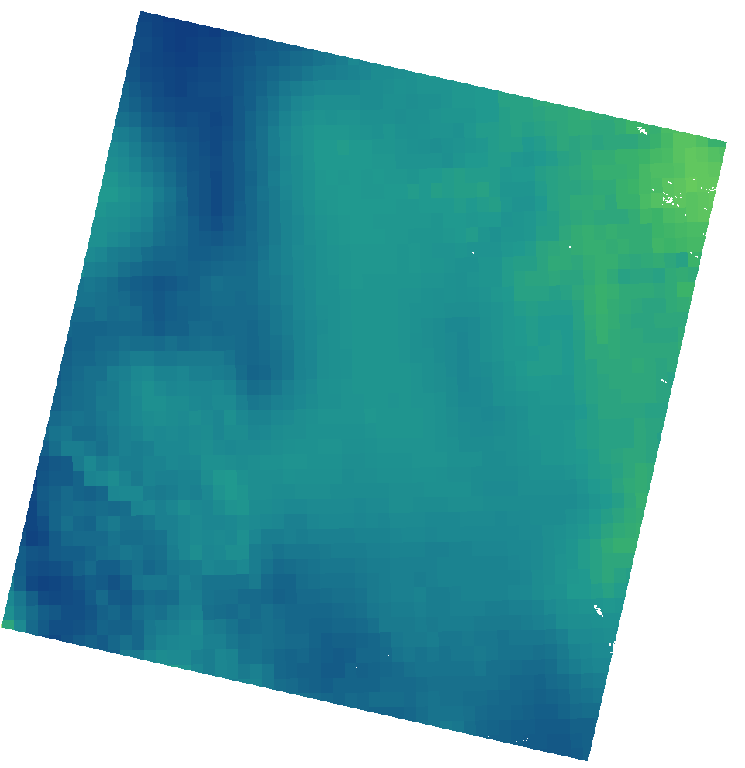

In [11]:
# Clip and project to the Landsat image footprint and coordinate system
image_url = model_obj.et_reference\
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET fraction

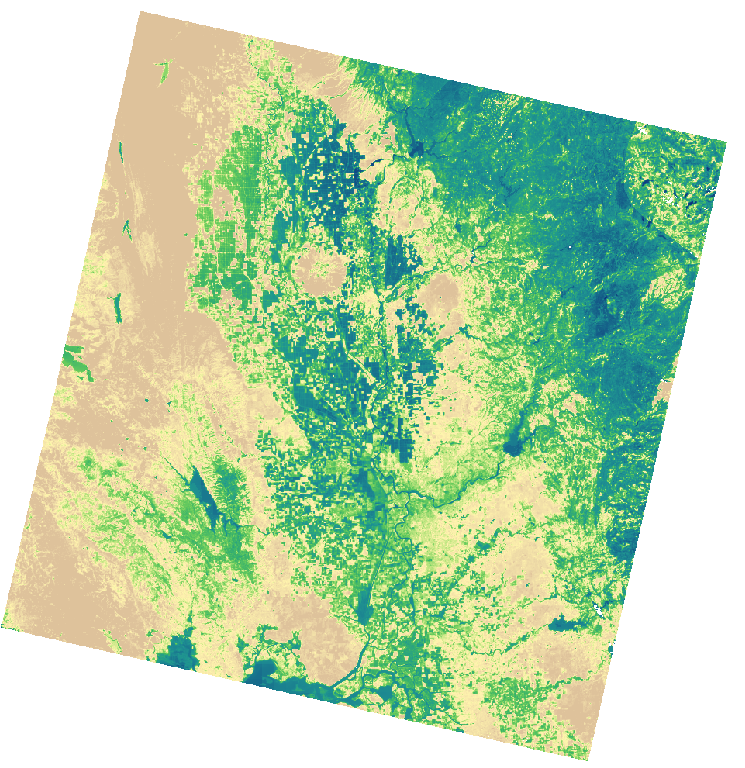

In [12]:
image_url = model_obj.et_fraction\
    .getThumbURL({'min': 0.0, 'max': 1, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### "Calculate" Method

Return a multiband image of the model variables

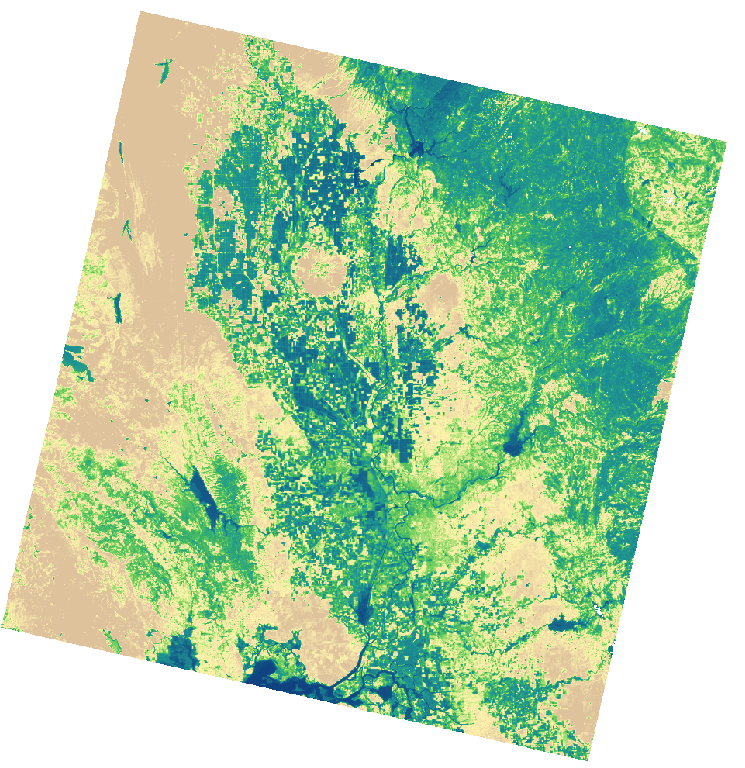

In [13]:
image_url = model_obj.calculate(['et', 'et_fraction']).select(['et'])\
    .getThumbURL({'min': 0.0, 'max': 8, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')